In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import torch


import matplotlib.pyplot as plt
from torch import nn #neural network module
from torch import optim  #optimizer module

In [0]:
from torchvision import datasets,transforms,models

## Downloading Dataset from Kaggle


In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list -s dogs

ref                                                  title                                           size  lastUpdated          downloadCount  
---------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
rahul897/catsdogs                                    cats&dogs                                      216MB  2018-01-05 15:02:32           1449  
jessicali9530/stanford-dogs-dataset                  Stanford Dogs Dataset                          735MB  2019-02-13 05:45:25           3342  
mauricefreund/cats-vs-dogs                           cats_vs_dogs                                     6MB  2017-11-06 13:28:08            196  
mmoreaux/audio-cats-and-dogs                         Audio Cats and Dogs                             49MB  2017-10-05 09:40:26           1819  
chetankv/dogs-cats-images                            Dogs & Cats Images                             216MB  2018-04-19 18:20:08          

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d biaiscience/dogs-vs-cats  


 98% 796M/814M [00:17<00:00, 24.4MB/s]
100% 814M/814M [00:17<00:00, 49.3MB/s]


In [0]:
!cd ~/.kaggle

In [0]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [0]:
import os
import zipfile

local_zip = 'dogs-vs-cats.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dogs-vs-cats/')
zip_ref.close()

In [0]:
!cd dogs-vs-cats


In [0]:
ls

test.zip  train.zip


In [0]:
local_zip = 'test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test/')
zip_ref.close()



In [0]:
local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('train/')
zip_ref.close()

In [0]:
data_dir='/content/dogs-vs-cats'

Before training, we can augment images using transforms.Compose()

## Load Data

In [0]:
#means 0.485,0.456,0.406
#sd 0.229,0.224,0.225
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

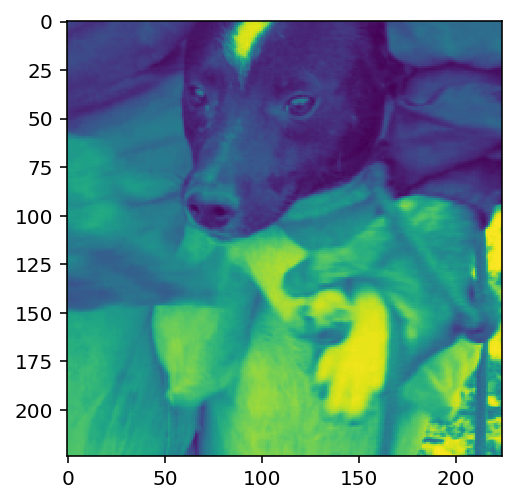

In [0]:
data_iter = iter(testloader)
images, labels = next(data_iter)
plt.imshow(images[0][1].numpy())

## Transfer Learning from model trained in ImageNet

In [0]:
model=models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 40301740.17it/s]


In [0]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

there are 2048 input features and 1000 output features in this Densenet model.
We need to freeze some


In [0]:
# Use GPU if it's available
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Freeze feature parameters
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [0]:
epochs = 2
steps = 0
running_loss = 0
print_every = 2
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            ##validation mode
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()